# Project: Cifar10 classifier using P2 submission

---
## Step 0: Load The Data

In [41]:
from keras.datasets import cifar10

# Load the training and test sets of Cifar10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# y_train and y_test(2-D) are single column multiple row arrays
# Convert both into a 1-D array
y_train = y_train[:,0]
y_test = y_test[:,0]

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

---
## Step 1: Dataset Summary & Exploration

In [42]:
### Replace each question mark with the appropriate value.
import pandas as pd

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of validation examples.
n_validation = len(X_validation)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = 10

# Print out some basic stats
print("Number of training samples =", n_train)
print("Number of validation samples =", n_validation)
print("Number of testing samples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training samples = 40000
Number of validation samples = 10000
Number of testing samples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


----

## Step 2: Visualize the different classes of images

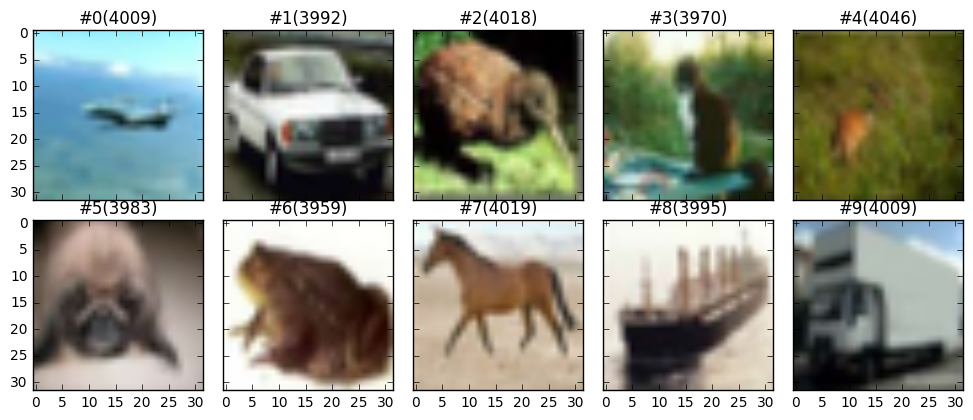

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# Define the size of the figure
figure = plt.figure(figsize=(12, 12))
# A grid for displaying the images
grid = ImageGrid(figure, 111, nrows_ncols=(2, 5), axes_pad=0.2)

# Variable to store the length of the largest class
largest_class = 0

# Go through each sign ID and display one of the images associated with
# the sign ID from the training set
for sign_id in range(0, 10):
    # np.where returns a tuple of arrays
    # first array points to the rows and the second array points to the columns
    # NOTE: y_train is a 1-D array
    image_index = np.where(y_train==sign_id)
    sign_image = X_train[image_index[0][0]]
    title = "#" + str(sign_id) + "(" + str(len(image_index[0])) + ")"
    grid[sign_id].imshow(sign_image)
    grid[sign_id].set_title(title)
    if(len(image_index[0]) > largest_class):
        largest_class = len(image_index[0])

plt.show()

----

## Step 3: Preprocess the Dataset

In [44]:
### Preprocess the data here.
import cv2
from sklearn.preprocessing import MinMaxScaler

def grayscaleImages(imageSet):
    '''
    Applies gray scaling on the images
    '''
    imageSet_gray = np.zeros([imageSet.shape[0], imageSet.shape[1], imageSet.shape[2]])

    for image_index in range(0, len(imageSet)):
        imageSet_gray[image_index] = cv2.cvtColor(imageSet[image_index].astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    return imageSet_gray

def normalizeImages(imageSet):
    '''
    Normalizes the images within the range of 0.1-1.9
    '''
    min_max_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    
    for image_index in range(0, len(imageSet)):
        imageSet[image_index] = min_max_scaler.fit_transform(imageSet[image_index])
    
    return imageSet

# Convert the new training, validation and old test set to gray scale
X_train = grayscaleImages(X_train)
X_validation = grayscaleImages(X_validation)
X_test = grayscaleImages(X_test)

# Normalize the sets
X_train = normalizeImages(X_train)
X_validation = normalizeImages(X_validation)
X_test = normalizeImages(X_test)

# Need to reshape it for it to be acceptable as input to LeNet algorithm which is in the form
# 32x32xC(where C is the number of channels which in this case 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

----

## Step 4: Use Architecture from P2

In [45]:
### Define your architecture here.
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

# LeNet model for German traffic dataset
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.2
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    W_conv1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 10), mean = mu, stddev = sigma))
    b_conv1 = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1

    # Activation.
    conv1 = tf.nn.elu(conv1)

    # Pooling. Input = 28x28x10. Output = 14x14x10.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x30.
    W_conv2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 30), mean = mu, stddev = sigma))
    b_conv2 = tf.Variable(tf.zeros(30))
    conv2   = tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2
    
    # Activation.
    conv2 = tf.nn.elu(conv2)

    # Pooling. Input = 10x10x30. Output = 5x5x30.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x30. Output = 750.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 750. Output = 450.
    W_fc1 = tf.Variable(tf.truncated_normal(shape=(750, 450), mean = mu, stddev = sigma))
    b_fc1 = tf.Variable(tf.zeros(450))
    fc1   = tf.matmul(fc0, W_fc1) + b_fc1
    
    # Activation.
    fc1    = tf.nn.elu(fc1)

    # Layer 4: Fully Connected. Input = 450. Output = 150.
    W_fc2  = tf.Variable(tf.truncated_normal(shape=(450, 150), mean = mu, stddev = sigma))
    b_fc2  = tf.Variable(tf.zeros(150))
    fc2    = tf.matmul(fc1, W_fc2) + b_fc2
    
    # Activation.
    fc2    = tf.nn.elu(fc2)

    # Layer 5: Fully Connected. Input = 150. Output = 10.
    W_fc3  = tf.Variable(tf.truncated_normal(shape=(150, 10), mean = mu, stddev = sigma))
    b_fc3  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, W_fc3) + b_fc3
    
    return logits

# Placeholders for training in batches
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# One hot encoding 
one_hot_y = tf.one_hot(y, 10)

rate = 0.001

# Softmax, cross entropy, optimizer, learning rate
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy of predictions
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Object of type Saver to save and load model
model_saver = tf.train.Saver()

# Evalutaion
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

----

## Step 5: Train the Model

In [46]:
from sklearn.utils import shuffle
### Train your model here.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # NOTE: Once the saver object is defined it can be used to save (or restore).
    # On a fresh session this might fail
    model_saver.save(sess, 'lenet2')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.301

EPOCH 2 ...
Validation Accuracy = 0.357

EPOCH 3 ...
Validation Accuracy = 0.392

EPOCH 4 ...
Validation Accuracy = 0.439

EPOCH 5 ...
Validation Accuracy = 0.465

EPOCH 6 ...
Validation Accuracy = 0.494

EPOCH 7 ...
Validation Accuracy = 0.496

EPOCH 8 ...
Validation Accuracy = 0.491

EPOCH 9 ...
Validation Accuracy = 0.501

EPOCH 10 ...
Validation Accuracy = 0.515

EPOCH 11 ...
Validation Accuracy = 0.522

EPOCH 12 ...
Validation Accuracy = 0.527

EPOCH 13 ...
Validation Accuracy = 0.527

EPOCH 14 ...
Validation Accuracy = 0.526

EPOCH 15 ...
Validation Accuracy = 0.522

EPOCH 16 ...
Validation Accuracy = 0.515

EPOCH 17 ...
Validation Accuracy = 0.515

EPOCH 18 ...
Validation Accuracy = 0.514

EPOCH 19 ...
Validation Accuracy = 0.508

EPOCH 20 ...
Validation Accuracy = 0.510

Model saved


----

## Step 6: Test the model

In [47]:
# Test the model
with tf.Session() as sess:
    model_saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.511
